## Applying K25 to Lee

Dropsondes around 09-08 at 2300 UTC.

We have a SAR acquisition at 2200 UTC, however it is contaminated by rain at Rmax.

Alternatively we may consider the SAR image on 09-08 at 0925 UTC or the one on 09-09 at 0950 UTC.

TODO: regler le pb de phase;

TODO: tweaker le modele pour qu'il capture l'asymétrie observée. Ca vient du fait que j'ai négligé Ut, mais aussi u du/dr alors qu'il est significatif proche de la surface proche de Rmax (w dM/dz a aussi été négligé à tord puisqu'il est significatif dans l'eyewall); Par exemple est-ce que je peux appliquer un V(r - r_star) dans les coefficients ? Ou changer le vent gradient pour qu'il soit plus smooth (en fait juste lui imposer un 2Rmax)? 

Il faudrait arriver à mettre un décalage en (r - alpha * Rmax) sur les coefficients asymétriques, pour que le profil symétrique matche bien mais que les asymétries se décalent, avec le coefficient alpha certainement un peu plus grand ou un peu plus petit en fonction des directions relatives entre storm motion et wind shear.

Sinon juste accepter que je n'ai pas la bonne asymétrie/inflow angle mais dire que j'ai au moins l'inflow angle moyen, ce qui est déjà pas mal. A mettre dans la solution d'Alexis. J'utilise un modèle linéaire donc forcément c'est limitant.

TESTED: Je peux changer le vent gradient en lui imposant 2 * Rmax pour le rendre plus réaliste, mais le pb c'est que le vent de surface devient alors incohérent avec le SAR. En faisant ça la pente outer-core de l'asymétrie est bien matchée mais le max d'asymétrie Kepert est quand même très proche de Rmax, ce qui fait que l'asymétrie est largement surestimée dans le near-core.

TESTED: Je peux retarder le V dans les coefficients d'asymétrie de Rmax (i.e en prenant V(r - Rmax)), cela marche un peu et me permet de très bien matcher l'asymétrie dans le near-core. Comment justifier cela dans le modèle? L'asymétrie est largement sous-estimée dans l'outer-core par contre;

Fitter avec la wind speed (et non avec l'asymétrie), et garder ces idées pour plus tard (alimentera la discussion du papier). Je peux aussi rajouter la vitesse de translation à l'extérieur du TC, çad dans la zone où V n'est plus >> Ut, en faisant un smoothing jusqu'à Rmax, pour augmenter mes asymétries artificiellement. En effet dans cette zone le modèle sous-estime l'asymétrie parce que Ut devrait être simplement sommé au champ de vent. Attention il y a du Vmin aussi qui prend déjà en compte la vitesse de translation, donc ajouter une fraction de Ut à la mano pour que ça matche les asymétries; Faire un smoothing linéaire jusqu'en Rmax.

TODO: Faire le code de fitting de C/sqrt(K) et c2; Utiliser uniquement la vitesse de vent, même pour c1, comme ça je pourrai fitter mon modèle à des images cropées

In [26]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [27]:
# Paths & Params
PTHS = {
    'iwp_dir': '/home/arthur/data/tropical_cyclones/IWRAP/',
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'dps_dir': '/home/arthur/data/tropical_cyclones/dropsondes/NOAA_field_experiment/samples/al132023/20230908H1_NETCDF/'
    # 'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/02_plotKepertAndSARasymmetries/',
}

In [417]:
# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

# Open TC
# ds  = dsg.where(dsg.name == 'LEE', drop=True).sortby('time').isel(time=1) # 12 hours before
ds  = dsg.where(dsg.name == 'LEE', drop=True).sortby('time').isel(time=3) # Collocated SAR acquisition
# ds  = dsg.where(dsg.name == 'LEE', drop=True).sortby('time').isel(time=4) # 12 hours after
dsp = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)

In [418]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2001 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, :])[0] # meteRs
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=1) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * abs((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, K, C, c1, c2, fcor):
    '''Note the error of parenthesis in his Eq. 29 - I re-computed the exact coefficients, the parenthesis should be removed.'''
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 - 1j * c2) * ki1 * [(3 + 1j) * ki0 * ki_1 + (2 - 2j) * (ki0 + ki_1) - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [(2 + 2j) * (1 + ki1 * ki_1) + 3 * ki1 + 3j * ki_1]
    return num / den

def A_1(Rs, Vs, K, C, c1, c2, fcor):
    '''Note the error of parenthesis in his Eq. 29 - I re-computed the exact coefficients, the parenthesis should be removed.'''
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 + 1j * c2) * ki_1 * [(3 + 1j) * ki0 * ki1 + (2 - 2j) * (ki0 + ki1) - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [(2 + 2j) * (1 + ki1 * ki_1) + 3 * ki_1 + 3j * ki1]
    return num / den

def A1_prime(Rs, Vs, K, C, c1, c2, fcor):
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 - 1j * c2) * ki1 * [(1 - 3j) * ki0 * ki_1 + (2 - 2j) * ki0 - (2 + 2j) * ki_1 - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [2 + 2j + 3 * (ki1 + ki_1) + (2 - 2j) * ki1 * ki_1]
    return num / den

def A_1_prime(Rs, Vs, K, C, c1, c2, fcor):
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 + 1j * c2) * ki_1 * [1j * (1 - 3j) * ki0 * ki1 + (2 - 2j) * ki0 + (2 + 2j) * ki1 - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [2 - 2j + 3 * (ki1 + ki_1) + (2 + 2j) * ki1 * ki_1]
    return num / den

# Thicknesses
def delta0(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor)))

def delta1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) + Vs / Rs))

def delta_1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) - Vs / Rs))

# Radial and tangential wind components
def u0(Rs, Vs, K, C, fcor, z, z_ref):
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * (z - z_ref) / delta0(Rs, Vs, K, fcor)))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor, z, z_ref):
    v0 = np.imag(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * (z - z_ref) / delta0(Rs, Vs, K, fcor)))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (z - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 + 1j) * (z - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (z - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 + 1j) * (z - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (z - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 - 1j) * (z - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (z - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 - 1j) * (z - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h):
    # Vs_dyd = np.concatenate((np.stack([np.ones(np.argmax(Vs)) for i in range(np.shape(Vs)[0])]) * Vs[0, 0], Vs), axis=1)[:, :np.shape(Vs)[1]]
    # return u_1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, z, z_ref, h) + u0(Rs, Vs, K, C, fcor, z, z_ref) + u1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, z, z_ref, h)
    return u_1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h) + u0(Rs, Vs, K, C, fcor, z, z_ref) + u1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h)

def v_BL(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h):
    # Vs_dyd = np.concatenate((np.stack([np.ones(np.argmax(Vs)) for i in range(np.shape(Vs)[0])]) * Vs[0, 0], Vs), axis=1)[:, :np.shape(Vs)[1]]
    # return Vs + v_1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, z, z_ref, h) + v0(Rs, Vs, K, C, fcor, z, z_ref) + v1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, z, z_ref, h)
    return Vs + v_1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h) + v0(Rs, Vs, K, C, fcor, z, z_ref) + v1(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h)

# FINAL MODEL
def kepert2025(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h):
    # Returns Kepert wind speeds
    u_K01   = u_BL(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h)
    v_K01   = v_BL(THs, Rs, Vs, K, C, c1, c2, fcor, z, z_ref, h)  

    # Not for K25!!!
    # # Adds the translation speed
    # Utu     = Ut * np.cos(THs) # Radial component of Ut
    # Utv     = -Ut * np.sin(THs) # Tangential component of Ut
    # # Utu = Utv = 0
    
    # return u_K01 + Utu, v_K01 + Utv
    return u_K01, v_K01

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(rs, ths, u_K01, v_K01):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('theta', 'rad'), np.sqrt(v_K01 ** 2 + u_K01 ** 2)),
            'rad_wind':   (('theta', 'rad'), u_K01),
            'tan_wind':   (('theta', 'rad'), v_K01),
        },
        coords={
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    '''Slower than its polar counterpart, because 4 interpolations are performed.'''
    kep_car = xr.Dataset(
        data_vars={
            'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
            'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
        },
        coords={
            'x': dim_ref,
            'y': dim_ref,
        }
    )
    return kep_car

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas - phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi, initial_condition],
        bounds=([0.01, 0., 0.1], [upper_bound, 2 * np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def get_kepert_asymmetries(THs, Rs, ths, rs, Vs, K, C, c1, c2, fcr, z_ref, h, valid_radii):
    # Estimate the wind at the top of the BL with the wind reduction factor
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf

    # Apply Kepert's model
    u_K25, v_K25 = kepert2025(THs, Rs, Vs_try, K, C, c1, c2, fcr, z_ref, z_ref, h) # Takes 3-4 seconds
    kep_pol      = get_xrDataset_polar(rs, ths, u_K25, v_K25)

    # Compute asymmetries on Kepert wind field
    aks         = []
    pks         = []
    # Iterate over all radii
    for rad in tqdm(valid_radii): # Iterate only in the valid range to optimize time
        ak, phi, _  = get_wn1(np.deg2rad(kep_pol.theta), kep_pol.wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, :]) / 3, np.max(Vs[0, :]))
        aks.append(ak)
        pks.append(phi)
    
    return aks, pks, kep_pol

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  = 0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [419]:
def get_z_kepert(THs, Rs, ths, rs, zs, Vs, K, C, c1, c2, fcr, z_ref, h):
    # Estimate the wind at the top of the BL with the wind reduction factor
    # LINES TO UNCOMMENT, JUST FOR THE CHECKING NOTEBOOK
    # Also change the inside of the kepert2025 call!!
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf
    # # And comment this line below instead:
    # Vs_try = Vs

    # Apply Kepert's model at each z
    # TODO: Vectorize all my functions?
    U_K01, V_K01 = [], []
    for z in tqdm(zs):
        u_K01, v_K01 = kepert2025(THs, Rs, Vs_try, K, C, c1, c2, fcr, z, z_ref, h) # Takes 3-4 seconds
        U_K01.append(u_K01)
        V_K01.append(v_K01)
    
    # Polar dataset
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('z', 'theta', 'rad'), np.sqrt(np.array(V_K01) ** 2 + np.array(U_K01) ** 2)),
            'rad_wind':   (('z', 'theta', 'rad'), np.array(U_K01)),
            'tan_wind':   (('z', 'theta', 'rad'), np.array(V_K01)),
        },
        coords={
            'z': zs,
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    print('Polar dataset created.')

    # Cartesian dataset
    KEP_CARS = []
    for z in tqdm(zs): # Takes ~20 seconds
        kep_car = xr.Dataset(
            data_vars={
                'wind_speed':   (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
                'rad_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'tan_wind':     (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'inflow_angle': (('x', 'y'), griddata((Xs.flatten(), Ys.flatten()), np.array(kep_pol.sel(z=z).inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
            },
            coords={
                'x': dim_ref,
                'y': dim_ref,
            }
        )
        KEP_CARS.append(kep_car)
    kep_car = xr.concat(KEP_CARS, 'z').assign_coords({'z': zs})
    print('Cartesian dataset created.')

    return kep_pol, kep_car

# For the expression see e.g Ueno and Kunii 2009
def get_w(kep_pol, kep_car, zs):
    # Compute vertical velocity by integrating continuity equation
    dru_dr = (kep_pol.rad * kep_pol.rad_wind).differentiate('rad') # d(ru)/dr
    dv_dth = kep_pol.tan_wind.differentiate('theta') / (2 * np.pi / 360) # dv/dtheta, dtheta converted in radians here
    # dv_dth = kep_pol.tan_wind.differentiate('theta')               # dv/dtheta
    WS_POL = []
    WS_CAR = []
    for z in tqdm(zs):
        integral = (dru_dr + dv_dth).sel(z=slice(None, z)).integrate('z')
        w_pol    = - (1 / integral.rad) * integral
        WS_POL.append(w_pol)
        w_car = griddata((Xs.flatten(), Ys.flatten()), np.array(w_pol.transpose()).flatten(), (x_ref, y_ref), method='nearest')
        WS_CAR.append(xr.DataArray(w_car, coords={'x': dim_ref,'y': dim_ref}))
    kep_pol['w'] = xr.concat(WS_POL, dim='z')
    kep_car['w'] = xr.concat(WS_CAR, dim='z')
    return kep_pol, kep_car

In [420]:
### FUNCTIONS TO COMPUTE ASYMMETRY AMPLITUDE
### FITS HOLLAND AT EACH RADIUS

def initialize_radius(spdm):
    '''Given the spdm, returns the largest radius (and asociated spdm) on which the profile can be fitted. 
    Indeed, sometimes the spdm isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(spdm)
    r                 = np.arange(last_valid_index) # to avoid having both r = 0 and n < 0 during fitting process
    
    ### Lower bound
    # We change it if spdm[0] = nan
    if np.isnan(spdm[0]):
        first_valid_index = np.min(np.where(np.isfinite(spdm)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.isnan(np.min(spdm[first_valid_index:])):
        last_valid_index  = np.min(np.where(np.isnan(spdm[first_valid_index:]))[0]) # returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
    # Define r and spdm
    r    = r[first_valid_index:last_valid_index] * 1000
    spdm = spdm[first_valid_index:last_valid_index]
    
    return r, spdm

# Test - Compute asymmetry by computing an average Holland per theta slice to smooth all the noise
BDS_HOL = {
    'B':      [0.01, 3.],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}

# Define the steps
# TODO: I could refine how I choose these steps to make them more continuous
# th_steps = np.linspace(0, 340, 341)
th_steps = np.linspace(0, 360, 19)[:-1] # Slice of 20 degrees
th_delta = 20 # degrees

In [523]:
#########################
###  HYPERPARAMETERS  ###
#########################
### Reference grids
# For K25
rs           = np.linspace(100, 5e5, 5000)
ths          = np.linspace(0, 2 * np.pi, 361)                         # in radians
# zs           = np.array([10, 110, 210, 310, 510, 1010, 1510, 2010])   # meters
zs           = np.array([10])
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

# To compute asymmetries
xs           = np.linspace(1000, 250000, 250)

# BL characteristics
z_ref = 10
h     = 1
C  = 1.5e-3            # fixed
# Ks = [1, 50, 100, 150] # trial
# Ks = [10, 20, 30, 40, 50, 100, 150] # trial
# Ks = [50, 100]
# Ks = [10, 25]
Ks = [1, 5]
# Ks = [100]
# c1 = -0.21
# c2 = 0.7
c1 = -0.27
c2 = 0.9


# Colors
truncated_Reds = truncate_colormap(mpl.cm.Reds, 0.2, 1.)
colors         = truncated_Reds(np.linspace(0, 1, len(Ks)))

In [524]:
c2 * c1_c2

np.float64(0.7198707087324203)

In [423]:
#########################
###  DET. PARAMETERS  ###
#########################
vmx = float(ds.vmx_hol)
rmx = float(ds.rmx_hol)
vmn = float(ds.vmn_hol)
B   = float(ds.B_hol)
lat = float(ds.lat)
fcr = abs(float(ds.fcor))
Ut  = float(ds.speed)

# Holland with fixed parameters
# V   = holland_profile(rs, lat, B, vmn, 2 * rmx, vmx)
V   = holland_profile(rs, lat, B, vmn, rmx, vmx)
# V   = np.concatenate((np.ones(np.argmax(V)) * V[0], V))[:len(V)]
Vs  = np.stack([V for i in range(np.shape(THs)[0])]) # Shape (361, 5000)

In [424]:
# plt.plot(rs, np.concatenate((np.ones(np.argmax(V)) * V[0], V))[:len(V)])
# plt.plot(rs, V)

In [425]:
# plt.plot(rs, holland_profile(rs, lat, B, vmn, rmx, vmx))
# plt.plot(rs, holland_profile(rs, lat, B, vmn, 2 * rmx, vmx))
# plt.xlim(0, 250000)

In [426]:
LWS = [] # To save the Holland wind speeds
ERR = [] # To compute RMSE
ACN = [] # Amplitude of cosine
PHS = [] # Phase of cosine
VTS = [] # Nb of valid thetas

for th in tqdm(th_steps):
    ds_slice          = dsp.sel(theta=slice(th, th + th_delta))
    wsm               = ds_slice.wind_speed.mean(dim='theta', skipna=True)
    r_crop, spdm_crop = initialize_radius(np.array(wsm))

    try:
        # Holland
        popt, pcov = curve_fit(
            lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, lat, B, Vmin, Rmax, Vmax), 
            np.array(r_crop), 
            np.array(spdm_crop), 
            p0=[1.8, 5, 20 * 1000, 40], 
            bounds=(
                tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
            ) 
        ) 
        B_hol, vmn_hol, rmx_hol, vmx_hol = popt
        
    except RuntimeError:
        B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
    
    # Append
    LWS.append(holland_profile(rs, lat, B_hol, vmn_hol, rmx_hol, vmx_hol))

dsh = xr.Dataset(
    data_vars={
        'ws':        (('th', 'rad'), LWS),
    },
    coords={
        'th': th_steps,
        'rad': rs,
    }
)

for rad in tqdm(xs):
# for rad in tqdm(xs):
    # Amplitude of cosine
    acn, phi, c   = get_wn1(np.deg2rad(dsh.sel(rad=rad, method='nearest').th), dsh.sel(rad=rad, method='nearest').ws, float(ds.vps), float(ds.vmx))
    ACN.append(acn)
    PHS.append(phi)
    # Error
    error         = float(rmse(dsh.sel(rad=rad, method='nearest').ws, wn1(np.deg2rad(dsh.th), acn, phi, c))) 
    ERR.append(error)
    # Valid thetas
    VTS.append(len(dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta').theta))

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

In [427]:
# dsh.sel(rad=rad, method='nearest').ws.plot()
# plt.plot(dsh.th, wn1(np.deg2rad(dsh.th), acn, phi, c))

### Computing and imposing the ratio c1/c2

#### 1) Apply K25 with arbitrary C, K, c1 and c2

In [525]:
# We compute the phase of the cosine at 2 * Rmax
phs_2rmx = np.array(PHS)[xs >= 2 * rmx][0]
# We thus obtain the ratio c1 / c2
# Indeed, we must have h * arctan(c1 / c2) + 270° = phs_2rmx
c1_c2    = np.tan((phs_2rmx - 3 * np.pi / 2) / h)
print(c1_c2)

0.7998563430360226


In [429]:
# kep_pol, kep_car = get_z_kepert(THs, Rs, ths, rs, zs, Vs, K, C, c1, c2, fcr, z_ref, h)

In [430]:
# Kepert model
AKS      = dict.fromkeys(Ks)
PKS      = dict.fromkeys(Ks)
KEP_POLS = dict.fromkeys(Ks)
for i, K in enumerate(tqdm(Ks)):
    aks, pks, kep_pol = get_kepert_asymmetries(THs, Rs, ths, rs, Vs, K, C, c1, c2, fcr, z_ref, h, xs)
    AKS[K]       = aks
    PKS[K]       = pks
    KEP_POLS[K]  = kep_pol

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

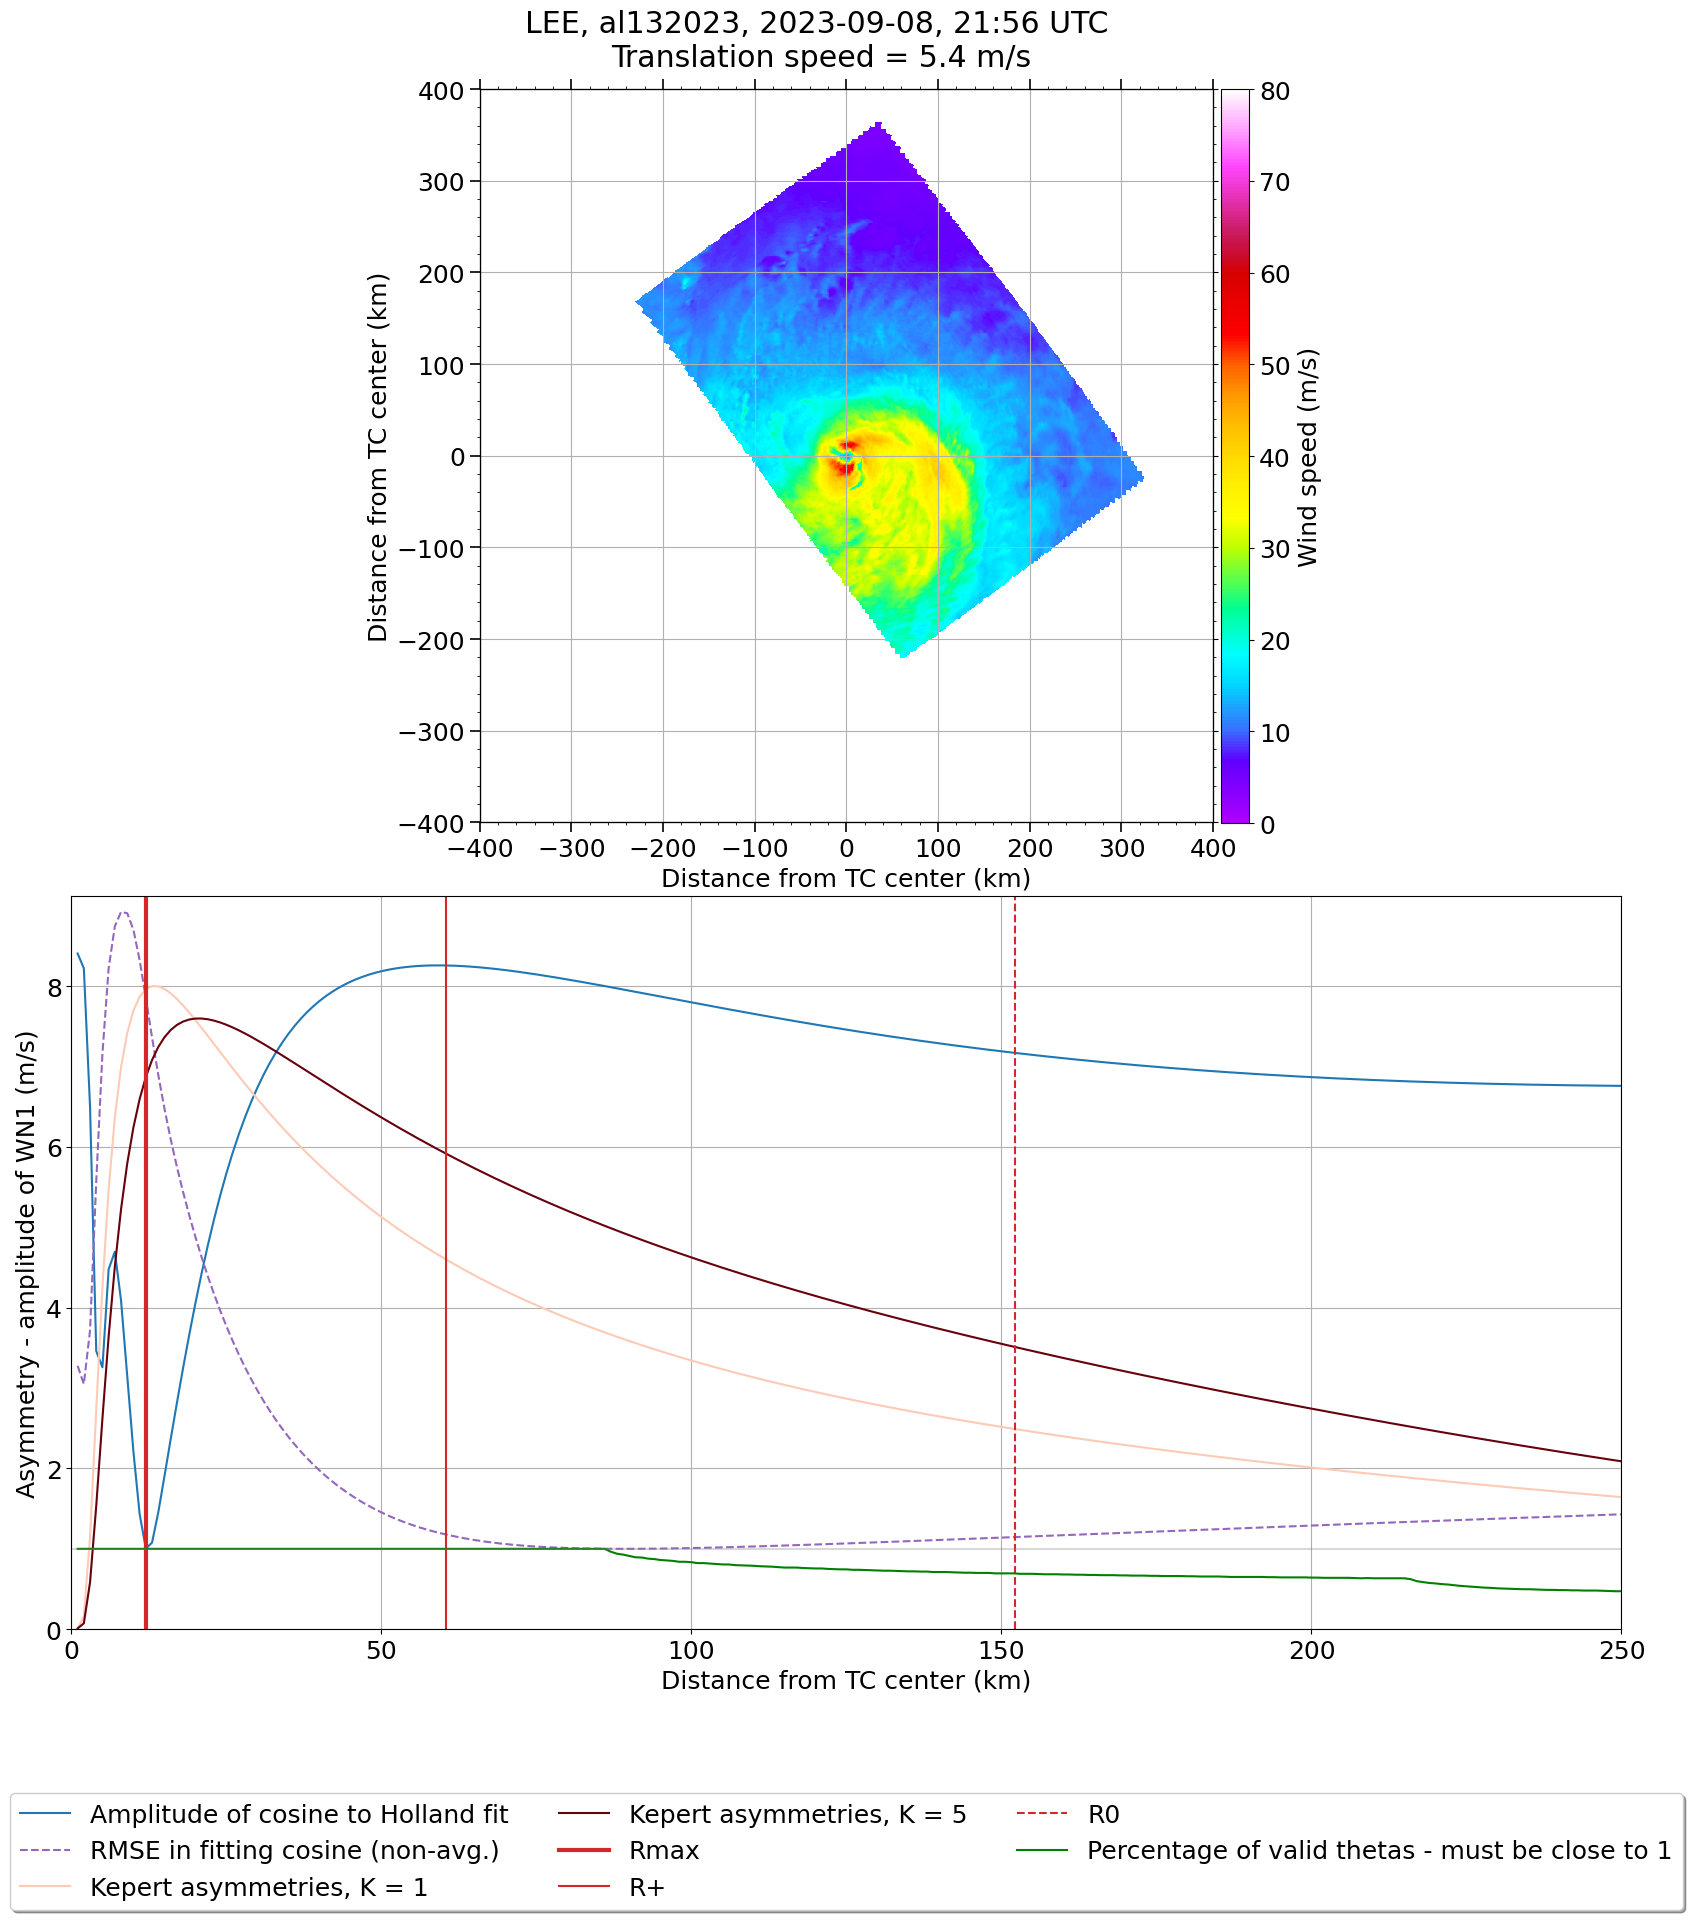

In [431]:
############
### Plot ###
############
fig          = plt.figure(figsize=(20, 20))
gs           = GridSpec(2, 1, hspace=0.1, wspace=0.01)
cmap         = plt.get_cmap('PuOr') # Spectral
normalizer   = Normalize(0, 80)
ax_lims2D    = 400
ts           = pd.to_datetime(str(ds.time.values)) 
d            = ts.strftime('%Y-%m-%d, %H:%M')
plt.suptitle('{}, {}, {} UTC \nTranslation speed = {:.1f} m/s'.format(ds.name.item(), ds.id.item(), d, ds.speed), y=0.92)

### Plot SAR
ax           = fig.add_subplot(gs[0, 0])
dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
ds_x, ds_y   = pol2cart(dr, th)
ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(), (x_ref, y_ref), method='linear')
im           = ax.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer)

# Axes
ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_ylabel(r'Distance from TC center (km)')
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.grid()

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=7, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Colorbar
cb_ax = fig.add_axes([0.7, 0.513, 0.014, 0.367])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(r'Wind speed (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

### Plot asymmetries (SAR + Kepert)
ax       = fig.add_subplot(gs[1, 0])

ax.plot(xs / 1000, ACN, c='tab:blue',                       label='Amplitude of cosine to Holland fit')
ax.plot(xs / 1000, ERR, c='tab:purple', linestyle='dashed', label='RMSE in fitting cosine (non-avg.)')
# Kepert asymmetry profiles
for i, K in enumerate(Ks):
    ax.plot(xs / 1000, AKS[K],                 c=colors[i],                        label='Kepert asymmetries, K = {}'.format(K))
# Wind radii
ax.axvline(ds.rmx / 1000,                      c='tab:red',    linewidth=3,        label='Rmax')
ax.axvline(ds.rps / 1000,                      c='tab:red',                        label='R+')
ax.axvline(ds.r0 / 1000,                       c='tab:red',    linestyle='dashed', label='R0')

# # I ~ V/r
# ax.axvline(ds.I_Vr1 / 1000,                    c='orange',                         label='I ~ V/r with SAR wind speed (not BL-top)')
# ax.axvline(ds.I_Vr2 / 1000,                    c='orange')

# Validity curves
ax.plot(xs / 1000, np.array(VTS) / 360., c='green',                          label='Percentage of valid thetas - must be close to 1')
# ax.plot(xs / 1000, Ut / Vs[0, idxs],      c='green',      linestyle='dashed', label='Ut / V - must remain small')
ax.axhline(1, c='gray', alpha=0.3)

# Legends
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_ylabel('Asymmetry - amplitude of WN1 (m/s)')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=3, fancybox=True, shadow=True)
ax.set_xlim(0, max(float(ds.r0 / 1000) + 5, 250))
ax.set_ylim(0, 0.2 + float(max(max(ACN), max(ERR))))
ax.grid()

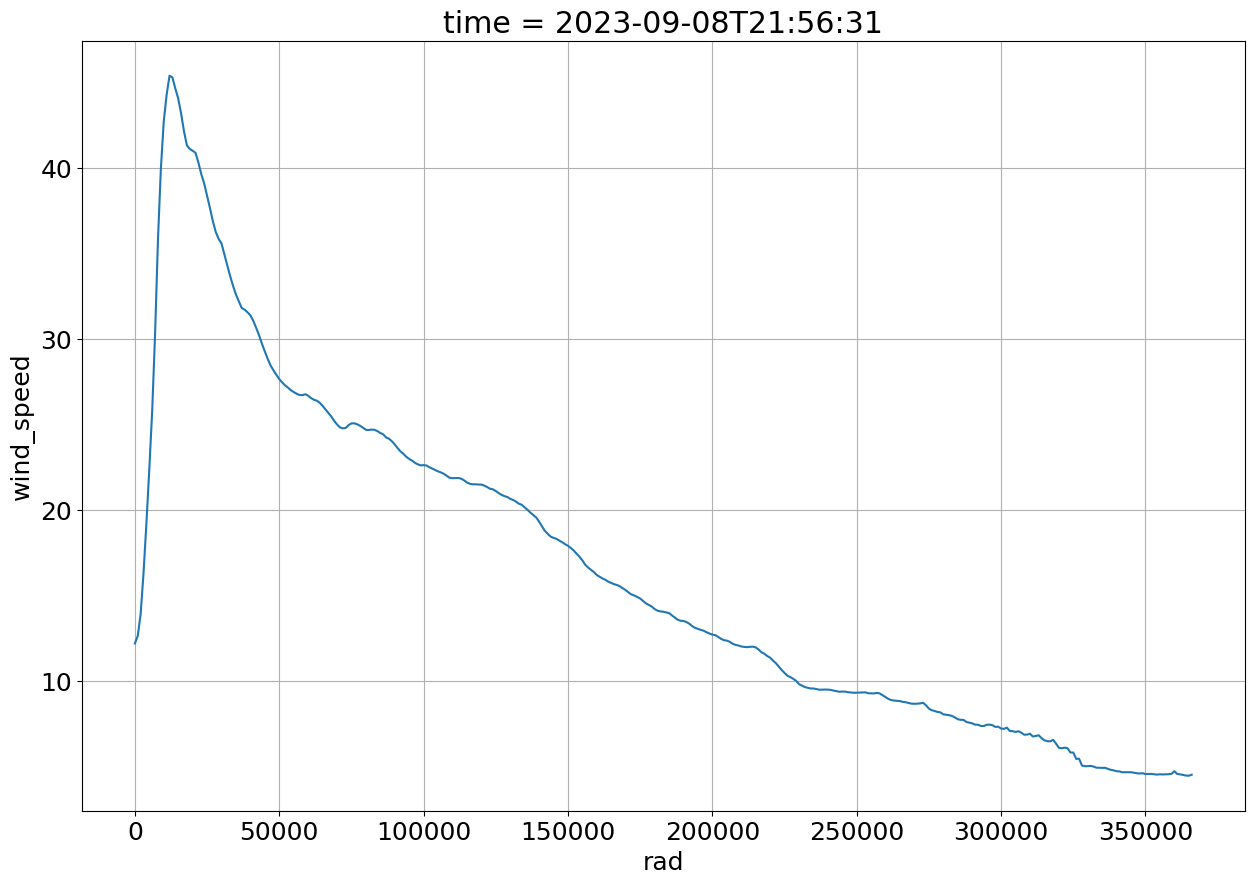

In [432]:
# KEP_POLS[10].wind_speed.mean(dim='theta').plot()
dsp.wind_speed.mean(dim='theta').plot()
plt.grid()

In [433]:
# (KEP_POLS[10] - KEP_POLS[25]).wind_speed.plot()

TODO: Enlever la fonction qui crée le dataset cartésien. Tout faire en polaire. Ca va prendre 3s par itération.

Try Ks = [1, 50, 100, 150, 200]

c1s    = [-2, -1, -0.5, 0., 1, 2.]

c2s    = [-2, -1, -0.5, 0., 1, 2.]

So 6x6x5x3 = less than 10 minutes

In [495]:
def get_kepert_polar_at_surface(THs, Rs, ths, rs, Vs, K, C, c1, c2, fcr, z_ref, h):
    wrf          = wind_reduction_factor(Rs, Vs, K, C, fcr) # azimuthal wind
    Vs_try       = Vs / wrf

    u_K01, v_K01 = kepert2025(THs, Rs, Vs_try, K, C, c1, c2, fcr, 10, z_ref, h) # Takes 3-4 seconds
    # print(np.shape(np.sqrt(np.array(v_K01) ** 2 + np.array(u_K01) ** 2)))
    
    # Polar dataset
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('theta', 'rad'), np.sqrt(np.array(v_K01) ** 2 + np.array(u_K01) ** 2)),
        },
        coords={
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    
    return kep_pol

In [496]:
kep_pol = get_kepert_polar_at_surface(THs, Rs, ths, rs, Vs, K, C, c1, c2, fcr, z_ref, h)
float(rmse(kep_pol.interp(coords={'rad': np.array(dsp.wind_speed.transpose().rad)}).sel(theta=slice(0, 359)).wind_speed, dsp.wind_speed.transpose()))

7.11562143750985

In [479]:
Ks  = [1, 50, 100, 150, 200]
c1s = [-2, -1, -0.5, 0., 1, 2.]
c2s = [-2, -1, -0.5, 0., 1, 2.]

In [500]:
RMSE = []

for K in tqdm(Ks):
    for c1 in c1s:
        for c2 in c2s:
            kep_pol = get_kepert_polar_at_surface(THs, Rs, ths, rs, Vs, K, C, c1, c2, fcr, z_ref, h)
            RMSE.append(float(rmse(kep_pol.interp(coords={'rad': np.array(dsp.wind_speed.transpose().rad)}).sel(theta=slice(0, 359)).wind_speed, dsp.wind_speed.transpose())))

  0%|          | 0/5 [00:00<?, ?it/s]

In [516]:
dar = xr.DataArray(
    np.array(RMSE).reshape((len(Ks), len(c1s), len(c2s))),
    coords={'K': Ks, 'c1': c1s, 'c2': c2s},
    dims=["K", "c1", "c2"],
)

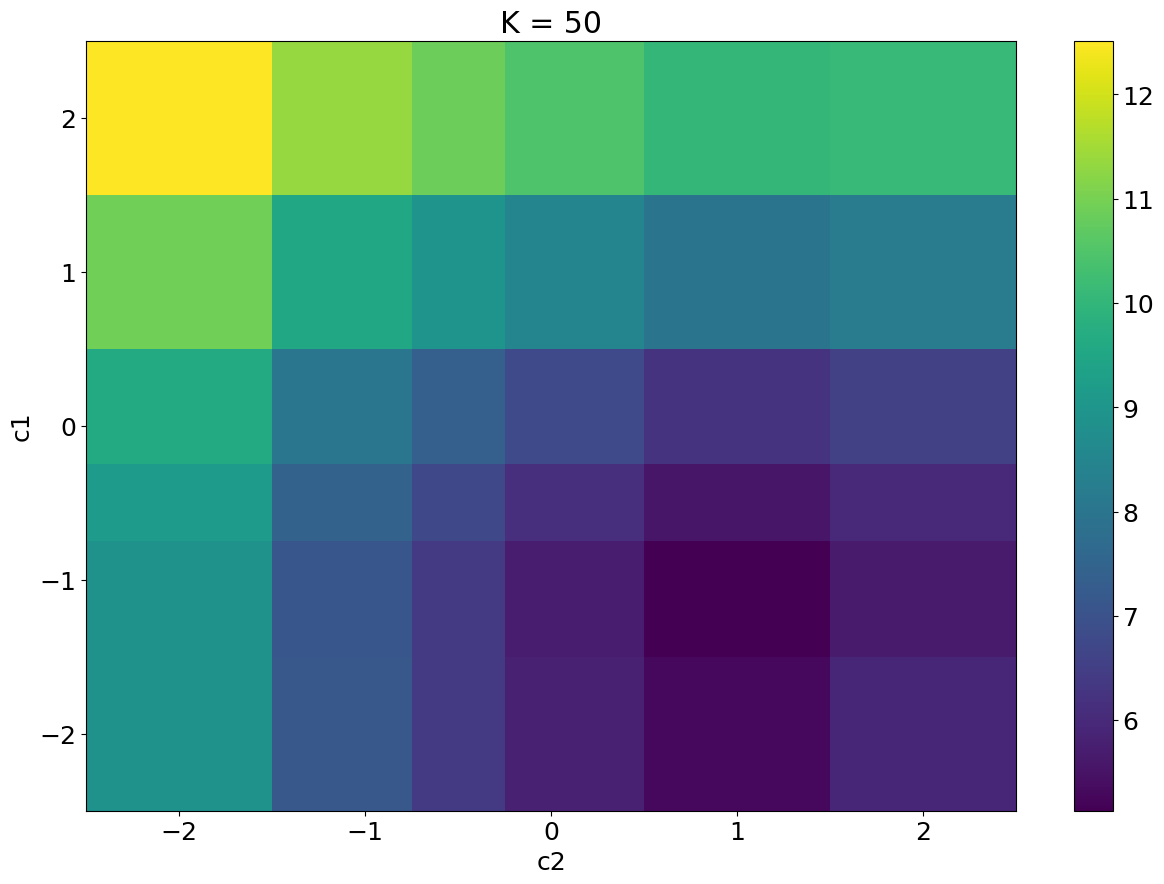

In [519]:
# dar.isel(K=1).plot()

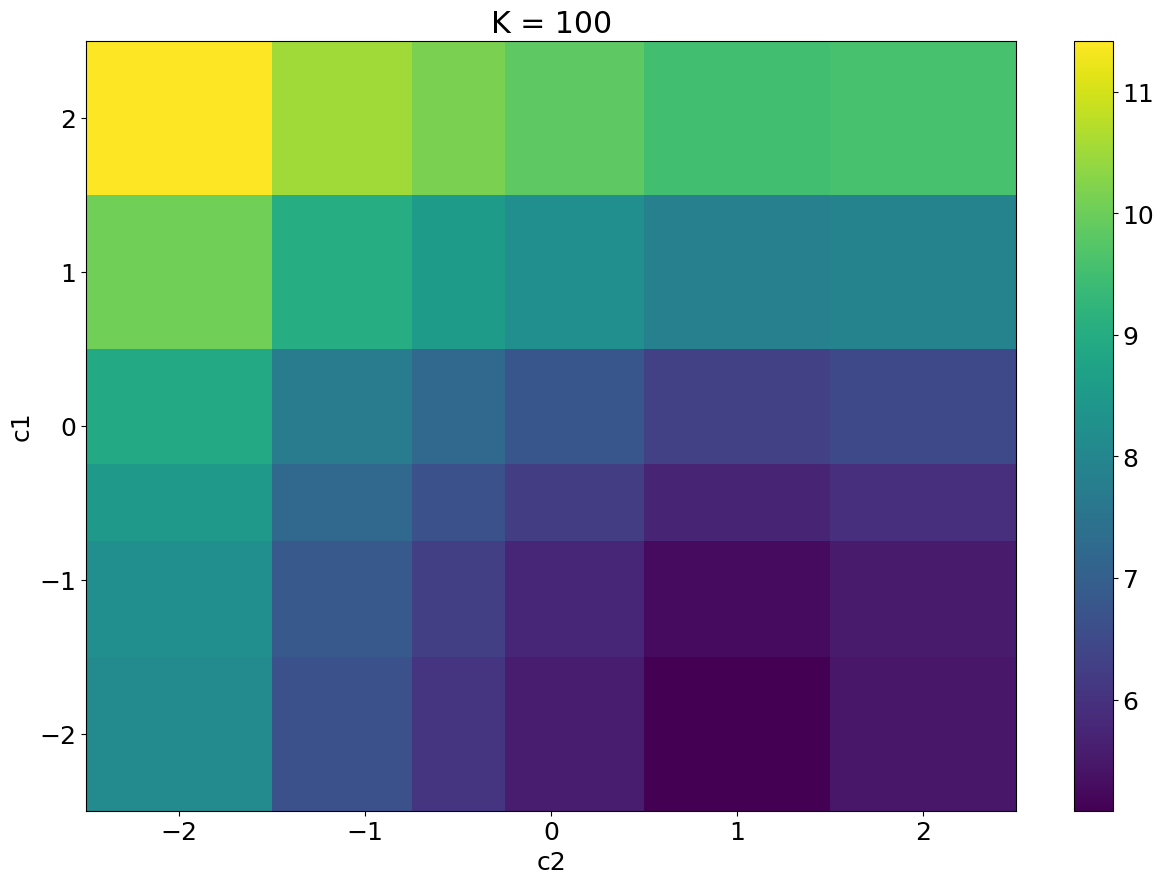

In [520]:
# dar.isel(K=2).plot()

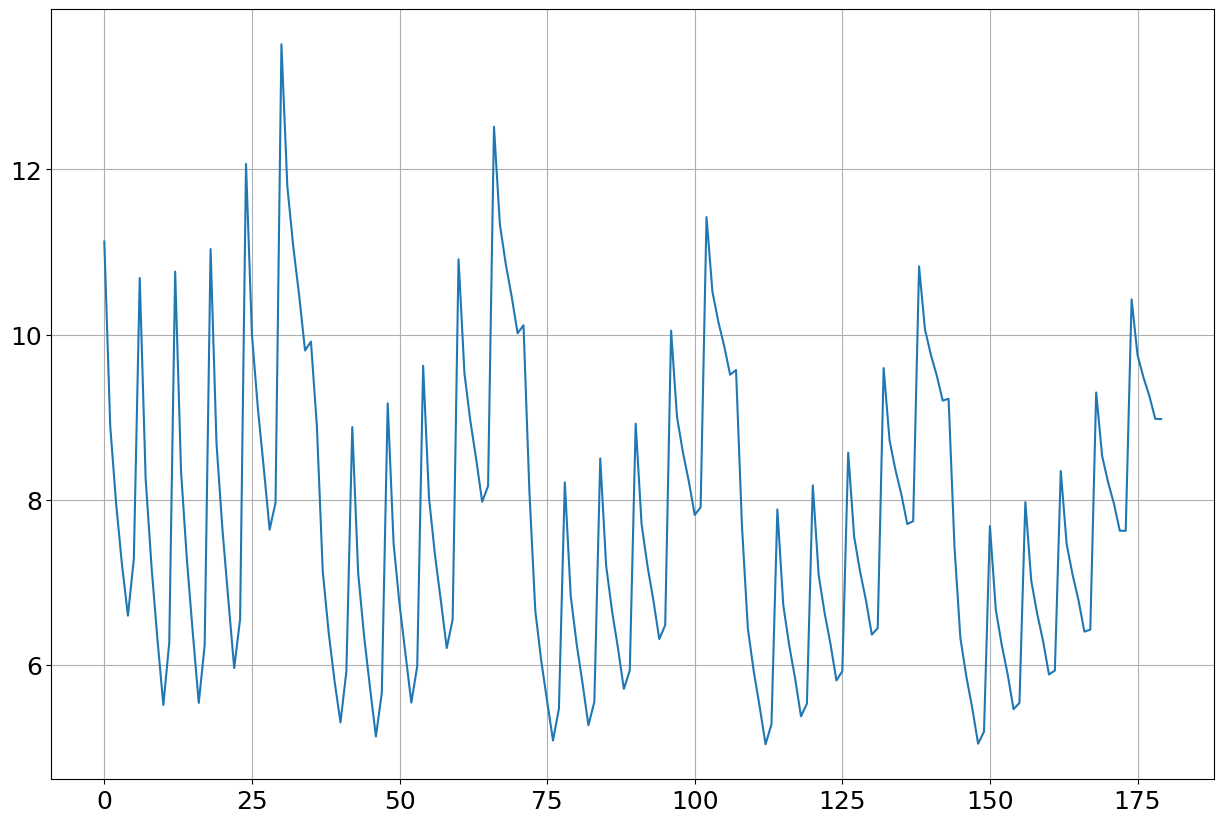

In [506]:
plt.plot(RMSE)
plt.grid()

#### 3) Impose the ratio c1/c2, with arbitrary C, and varying c2 and K

In [436]:
# c1s = [0.1, 0.2, 0.3, 0.4, 0.5]
# c2s = [1.0, 2.0]
# c2s = [0.2, 0.3]
# c2s = [0.6, 0.7, 0.8]
c2s = [0.7]
C   = 1.5e-3            # fixed
# Ks  = [1, 10, 25]
Ks  = [10]

In [437]:
import itertools
AKS      = {key: None for key in list(itertools.product(Ks, c2s))}
PKS      = {key: None for key in list(itertools.product(Ks, c2s))}
KEP_POLS = {key: None for key in list(itertools.product(Ks, c2s))}
for K in tqdm(Ks):
    for c2 in tqdm(c2s):
        c1                 = c2 * c1_c2
        aks, pks, kep_pol  = get_kepert_asymmetries(THs, Rs, ths, rs, Vs, K, C, c1, c2, fcr, z_ref, h, xs)
        AKS[(K, c2)]       = aks
        PKS[(K, c2)]       = pks
        KEP_POLS[(K, c2)]  = kep_pol

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

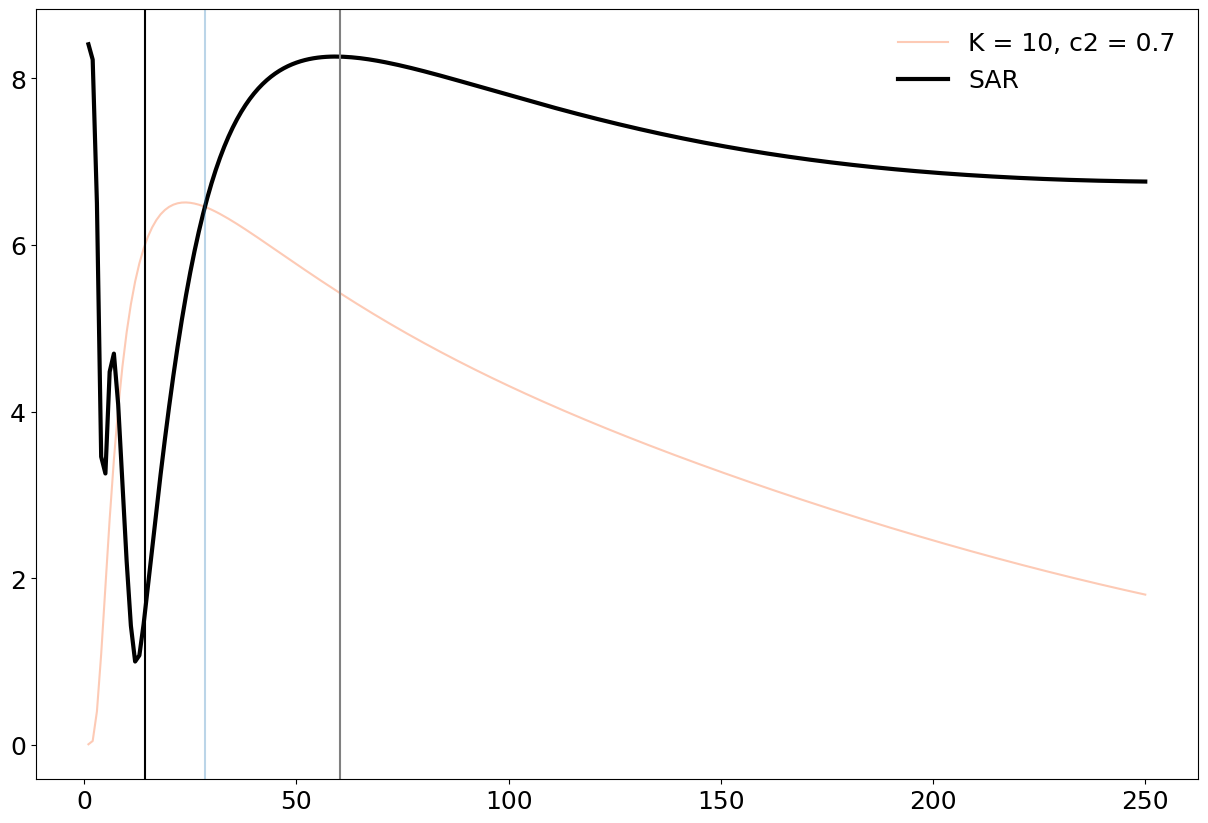

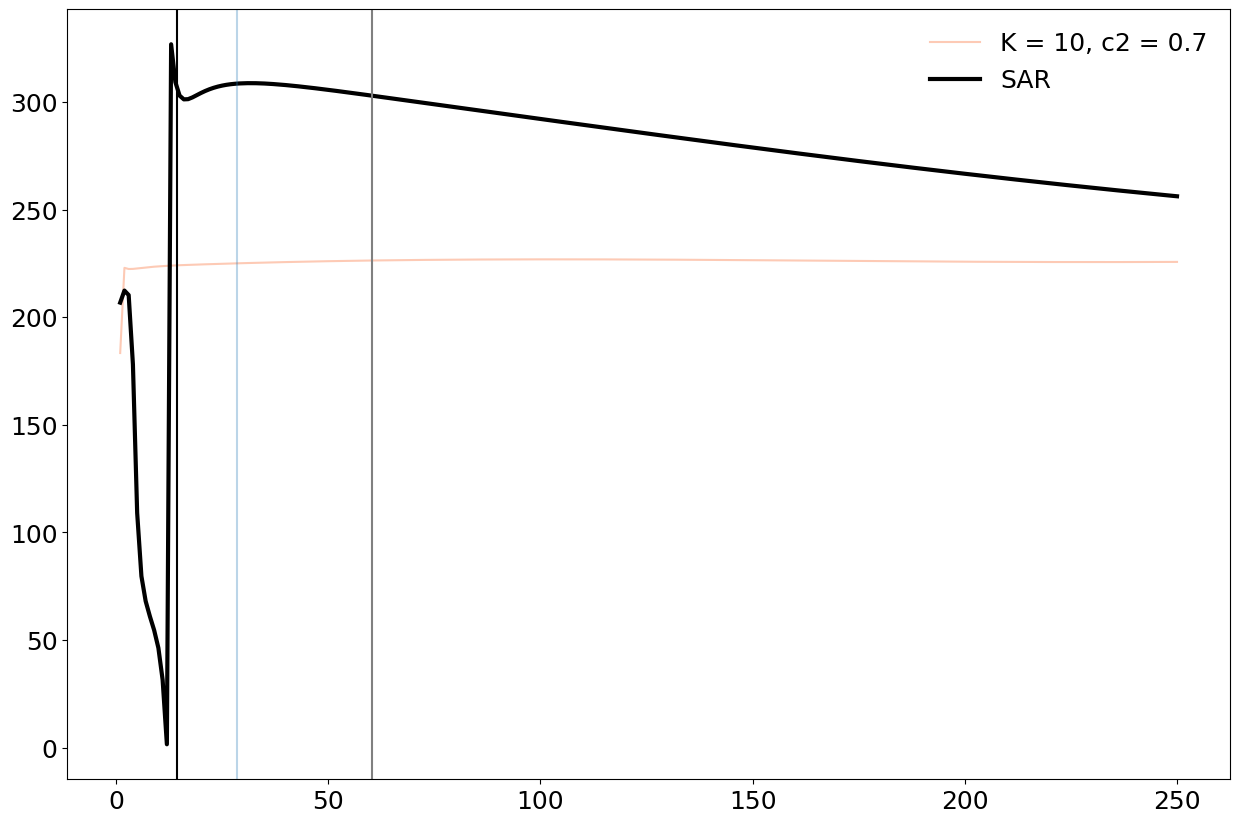

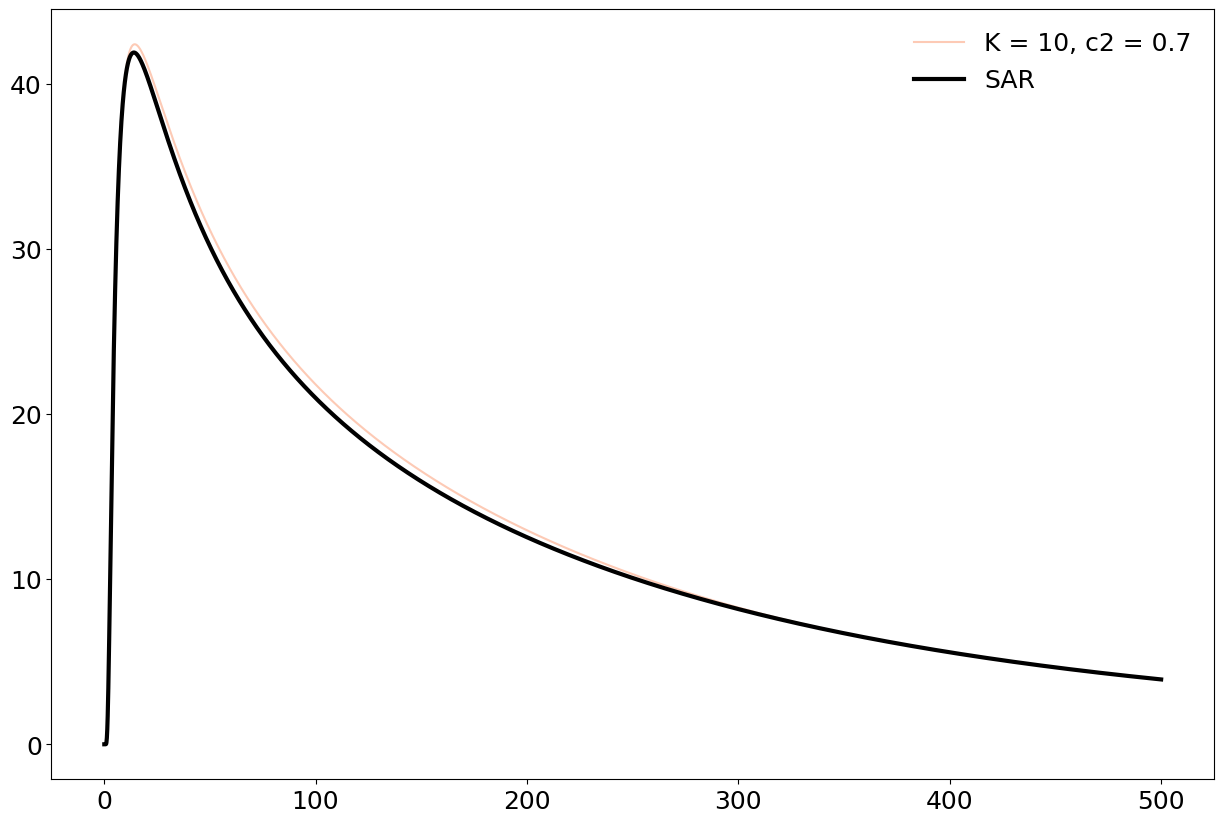

In [446]:
ltsls = ['solid', 'dashed', 'dotted']
clrs  = truncated_Reds(np.linspace(0, 1, len(c2s)))

for iK, K in enumerate(Ks):
    for ic2, c2 in enumerate(c2s):
        plt.plot(xs / 1000, AKS[(K, c2)], c=clrs[ic2], label='K = {}, c2 = {}'.format(K, c2), linestyle=ltsls[K // 10 - 1])
plt.plot(xs / 1000, ACN, c='k', linewidth=3, label='SAR')
plt.axvline(rmx / 1000,        c='k')
plt.axvline(ds.rps / 1000,     c='gray')
plt.axvline(2 * rmx / 1000,    c='tab:blue', alpha=0.3)
plt.legend(frameon=False)
plt.show()

for iK, K in enumerate(Ks):
    for ic2, c2 in enumerate(c2s):
        plt.plot(xs / 1000,  np.rad2deg(PKS[(K, c2)]), c=clrs[ic2], label='K = {}, c2 = {}'.format(K, c2), linestyle=ltsls[K // 10 - 1])
plt.plot(xs / 1000, np.rad2deg(PHS), c='k', linewidth=3, label='SAR')
plt.axvline(rmx / 1000,        c='k')
plt.axvline(ds.rps / 1000,     c='gray')
plt.axvline(2 * rmx / 1000,    c='tab:blue', alpha=0.3)
plt.legend(frameon=False)
plt.show()

for iK, K in enumerate(Ks):
    for ic2, c2 in enumerate(c2s):
        plt.plot(rs / 1000,  KEP_POLS[(K, c2)].wind_speed.mean(dim='theta'), c=clrs[ic2], label='K = {}, c2 = {}'.format(K, c2), linestyle=ltsls[K // 10 - 1])
plt.plot(rs / 1000, Vs[0, :], c='k', linewidth=3, label='SAR')
plt.legend(frameon=False)

In [441]:
# KEP_POLS[10, 0.7].wind_speed.mean(dim='theta').plot()
# dsp.wind_speed.mean(dim='theta').plot()

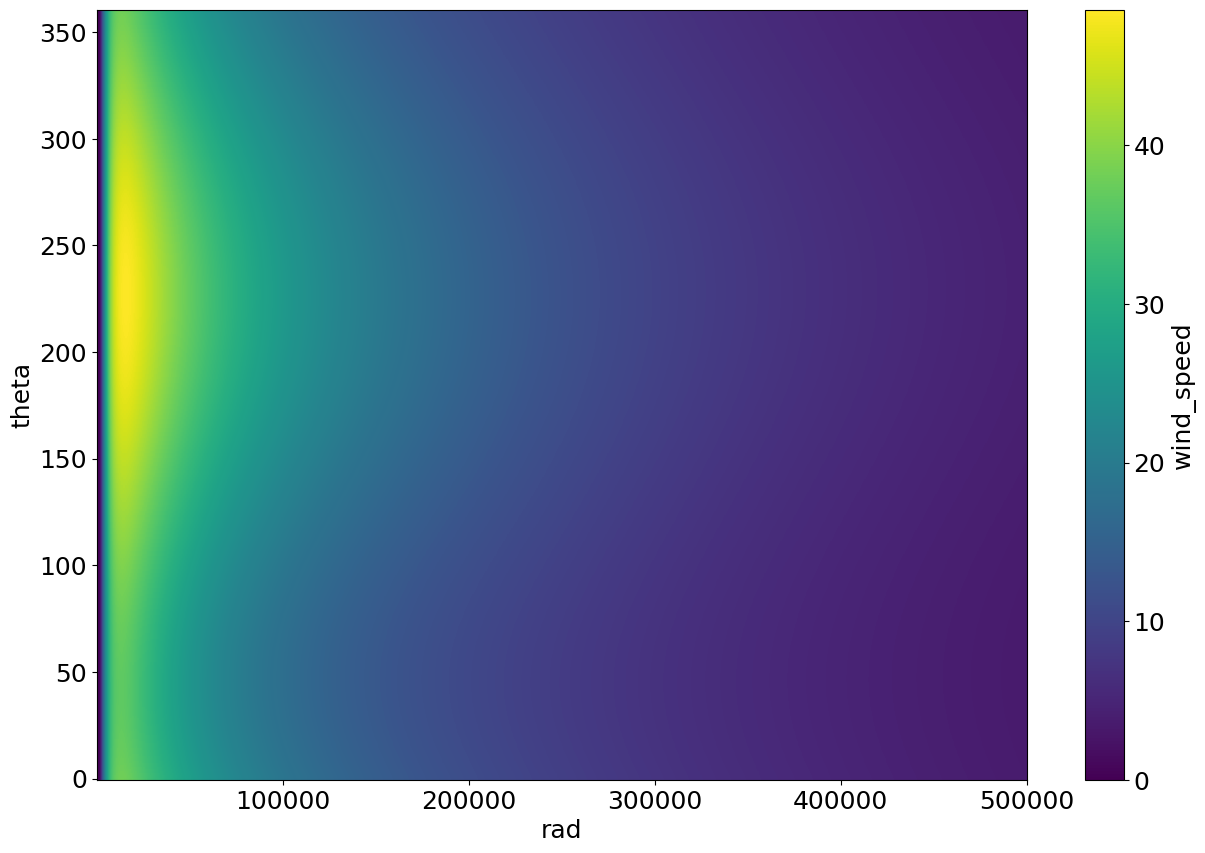

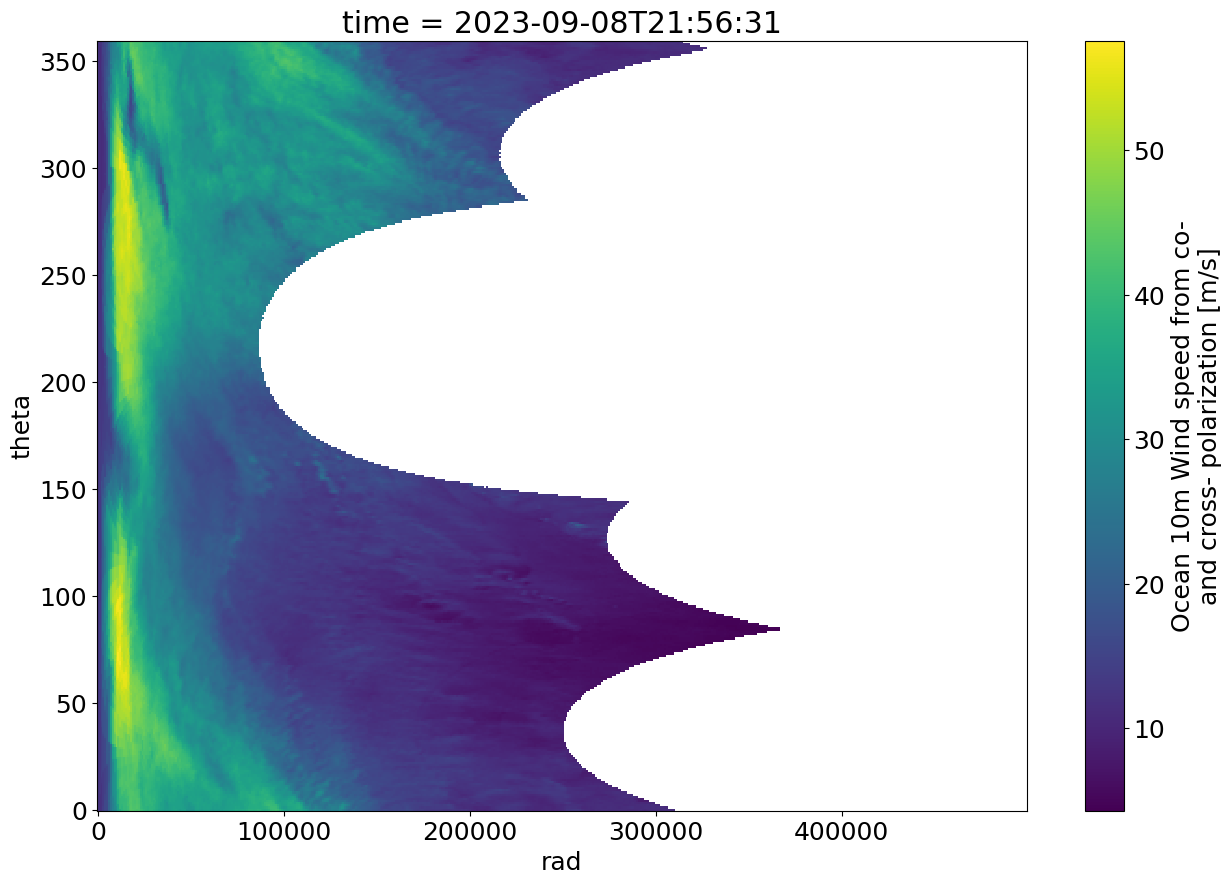

In [444]:
KEP_POLS[10, 0.7].wind_speed.plot()
plt.show()
dsp.wind_speed.transpose().plot()

### Calibrating with dropsondes

In [21]:
dps_all = glob.glob(PTHS['dps_dir'] + '*.nc')

In [22]:
from pyproj import CRS, Geod

### FUNCTIONS
def get_polar_theta(forward_az):
    '''INPUT: forward_az: 0° is North, 90° is East;
    OUTPUT: theta: 0° is East, 90° is North'''
    theta = (90 - forward_az) % 360 # 0° is North, 90° is East
    return theta

def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

def get_new_aircraft_coords_based_on_storm_motion(diwp, storm_dir, storm_speed, time_cen, lon_cen, lat_cen):
    '''storm_dir: usually float(ds.storm_dir_ibt), i.e degrees east of north
    storm_speed: usually float(ds.storm_speed_ibt), i.e m/s
    time_cen: usually ds.time, i.e np.datetime64 indicating the time of the considered center point
    lon_cen, lat_cen: usually float(ds.lon) and float(ds.lat), i.e coordinates of the storm center (degrees East and North)
    '''
    # Temps écoulé depuis le temps d'acquisition SAR
    dt              = diwp.time - time_cen
    diwp['dt_scds'] = xr.DataArray(
        data=np.array(dt.dt.days * 24 * 3600 + dt.dt.seconds),
        dims=['time']
    )
    diwp.dt_scds.attrs['description'] = 'Temps écoulé depuis le temps d acquisition SAR'

    # New longitudes/latitudes after moving x meters to a specified direction
    geod_wgs84            = CRS("epsg:4326").get_geod()
    new_lons, new_lats, _ = geod_wgs84.fwd(lons=diwp.lon, lats=diwp.lat, az=np.ones_like(diwp.lon) * storm_dir, dist=-diwp.dt_scds * storm_speed)
    
    diwp['new_lon']       = xr.DataArray(data=new_lons, dims=['time'])
    diwp['new_lat']       = xr.DataArray(data=new_lats, dims=['time'])
    diwp.new_lon.attrs['description'] = 'longitude of the point after correcting for storm motion'
    diwp.new_lat.attrs['description'] = 'latitude of the point after correcting for storm motion'

    # Compute polar coordinates
    geod_wgs84        = CRS("epsg:4326").get_geod()
    forward_az, _, dr = geod_wgs84.inv(np.ones_like(diwp.lon) * lon_cen, np.ones_like(diwp.lat) * lat_cen, diwp.new_lon, diwp.new_lat)
    th                = get_polar_theta(forward_az) # r is dr
    
    diwp['r']         = xr.DataArray(data=dr, dims=['time'])
    diwp['th']        = xr.DataArray(data=th, dims=['time'])
    diwp.r.attrs['description']  = 'radius of the point after correcting for storm motion'
    diwp.th.attrs['description'] = 'azimuth of the point after correcting for storm motion'

    # Compute cartesian coordinates
    x, y      = pol2cart(dr, np.deg2rad(th))
    diwp['x'] = xr.DataArray(data=x, dims=['time'])
    diwp['y'] = xr.DataArray(data=y, dims=['time'])
    diwp.x.attrs['description'] = 'x of the point after correcting for storm motion'
    diwp.y.attrs['description'] = 'y of the point after correcting for storm motion'

    return diwp

  0%|          | 0/31 [00:00<?, ?it/s]

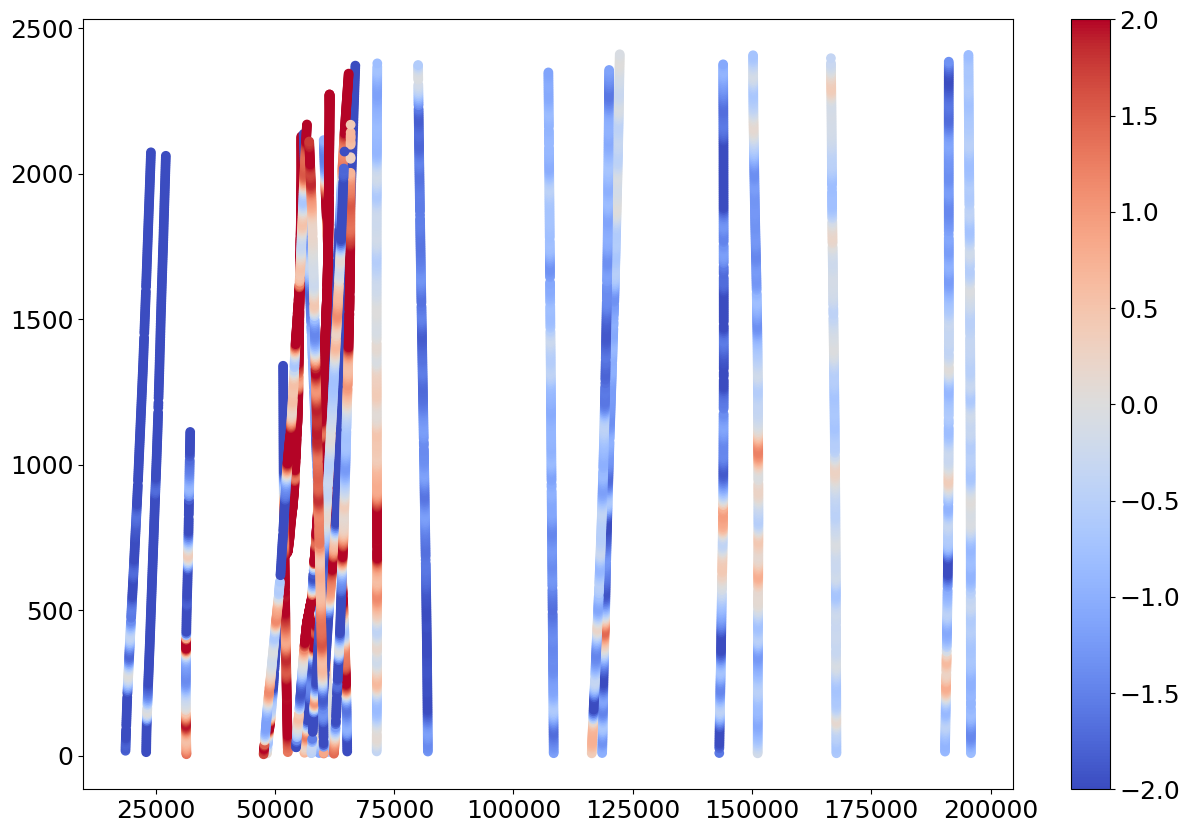

In [25]:
for file in tqdm(dps_all):
    dp        = xr.open_dataset(file)
    dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
    sc        = plt.scatter(dp.r, dp.alt, c=dp.w_wind, cmap='coolwarm', vmin=-2, vmax=2)
plt.colorbar(sc)

#### 1) Initialize 2 Kepert wind fields

In [50]:
zs           = np.array([10, 110, 210, 310, 510, 1010, 1510, 2010])   # meters

# BL characteristics
z_ref = 10
h     = 1
C     = 1.5e-3            # fixed
K     = 10
c2    = 0.9
c1    = c2 * c1_c2

In [51]:
kep_pol1, kep_car1 = get_z_kepert(THs, Rs, ths, rs, zs, Vs, K, C, c1, c2, fcr, z_ref, h)
kep_pol1, kep_car1 = get_w(kep_pol1, kep_car1, zs)

  0%|          | 0/8 [00:00<?, ?it/s]

Polar dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

Cartesian dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

In [52]:
K     = 25
c2    = 0.7
kep_pol2, kep_car2 = get_z_kepert(THs, Rs, ths, rs, zs, Vs, K, C, c1, c2, fcr, z_ref, h)
kep_pol2, kep_car2 = get_w(kep_pol2, kep_car2, zs)

  0%|          | 0/8 [00:00<?, ?it/s]

Polar dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

Cartesian dataset created.


  0%|          | 0/8 [00:00<?, ?it/s]

#### 3) Calibrate with total wind speed RMSE

In [53]:
dp_z_ref = np.linspace(0, 2000, 401)
DP_RADS  = []
DP_THS   = []
DP_HWS   = []

for file in tqdm(dps_all):
    try:
        dp        = xr.open_dataset(file)
        # Correct for storm movement and time difference
        dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
        # Add total wind speed
        dp['hws'] = np.sqrt(dp.u_wind ** 2 + dp.v_wind ** 2)
        # Interpolate on dp_z_ref
        ds_dp = xr.DataArray(data=np.array(dp.dropna(dim='time').hws), coords={'z': np.array(dp.dropna(dim='time').gpsalt)})
        ds_dp = ds_dp.where(~np.isnan(ds_dp.z)).dropna(dim='z') # Remove potential NaNs on coord z
        DP_HWS.append(np.array(ds_dp.interp(coords={'z': dp_z_ref})))
        # Add (r, th)-mean-coordinates
        DP_RADS.append(float(dp.r.mean()))
        DP_THS.append(float(dp.th.mean()))
    except ValueError:
        print('failed for file {}'.format(file))

# Concatenate in one big array
DP_OBS  = np.full((len(dp_z_ref), len(DP_THS), len(DP_RADS)), np.nan)
for idx in range(len(DP_RADS)):
    DP_OBS[:, idx, idx] = DP_HWS[idx]

  0%|          | 0/31 [00:00<?, ?it/s]

failed for file /home/arthur/data/tropical_cyclones/dropsondes/NOAA_field_experiment/samples/al132023/20230908H1_NETCDF/D20230909_014833_PQC.nc
failed for file /home/arthur/data/tropical_cyclones/dropsondes/NOAA_field_experiment/samples/al132023/20230908H1_NETCDF/D20230909_003248_PQC.nc
failed for file /home/arthur/data/tropical_cyclones/dropsondes/NOAA_field_experiment/samples/al132023/20230908H1_NETCDF/D20230908_234103_PQC.nc
failed for file /home/arthur/data/tropical_cyclones/dropsondes/NOAA_field_experiment/samples/al132023/20230908H1_NETCDF/D20230909_003514QC.nc
failed for file /home/arthur/data/tropical_cyclones/dropsondes/NOAA_field_experiment/samples/al132023/20230908H1_NETCDF/D20230909_001041_PQC.nc


In [54]:
# Compute RMSE
rmse(kep_pol1.interp(coords={'rad': DP_RADS, 'theta': DP_THS, 'z': dp_z_ref}).wind_speed, DP_OBS)

<xarray.DataArray 'wind_speed' ()> Size: 8B
array(13.29762971)

In [55]:
rmse(kep_pol2.interp(coords={'rad': DP_RADS, 'theta': DP_THS, 'z': dp_z_ref}).wind_speed, DP_OBS)

<xarray.DataArray 'wind_speed' ()> Size: 8B
array(14.04797671)

  0%|          | 0/31 [00:00<?, ?it/s]

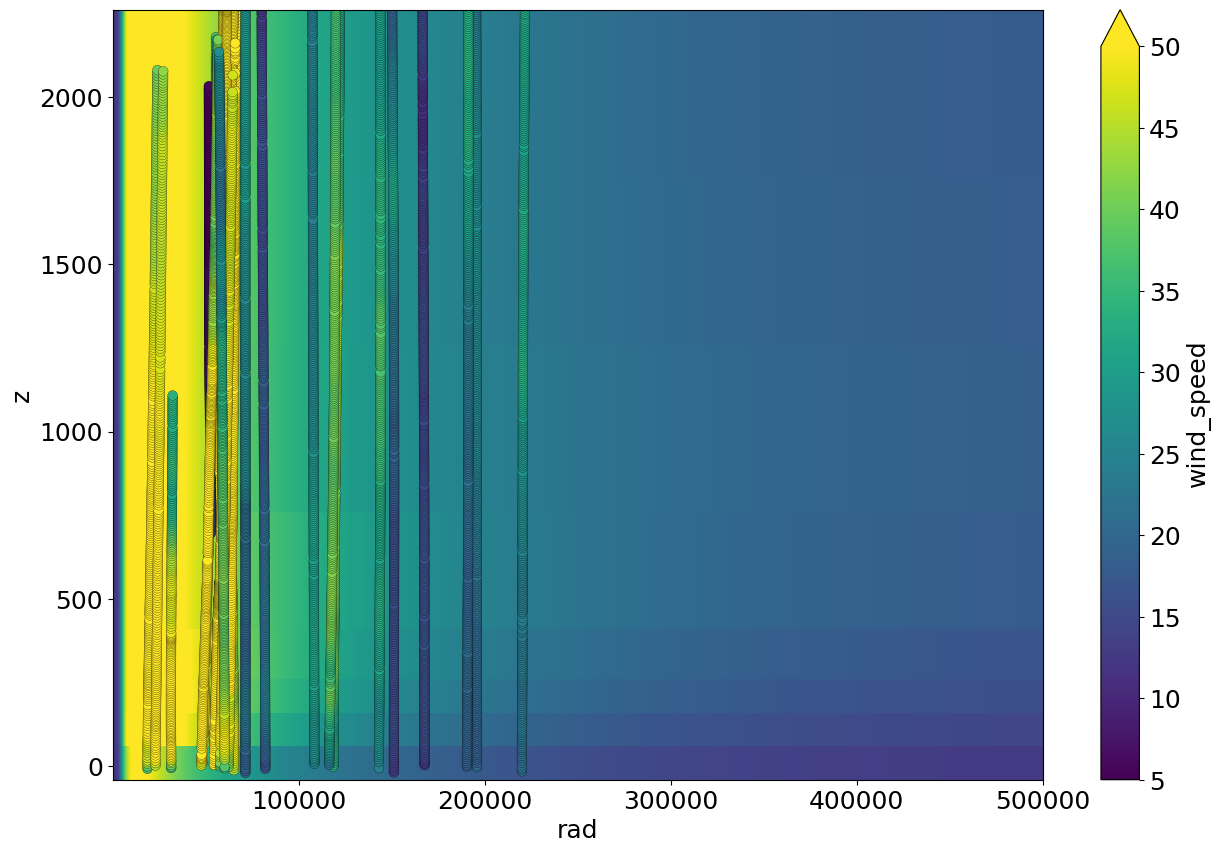

In [57]:
cvmax = 50

kep_pol1.mean(dim='theta').wind_speed.plot(vmin=5, vmax=cvmax, cmap='viridis')
# dsp.wind_speed.transpose().plot(vmin=5, vmax=40, cmap='viridis')
for file in tqdm(dps_all):
    dp        = xr.open_dataset(file)
    dp        = get_new_aircraft_coords_based_on_storm_motion(dp, float(ds.storm_dir_ibt), float(ds.storm_speed_ibt), ds.time, float(ds.lon), float(ds.lat))
    dp['hws'] = np.sqrt(dp.u_wind ** 2 + dp.v_wind ** 2)
    plt.scatter(dp.r, dp.gpsalt, c=dp.hws, vmin=5, vmax=cvmax, cmap='viridis', edgecolor='black', linewidth=0.2, s=50)